# 05 — Emotion features (GoEmotions)

Train a multi-label emotion classifier on the Kaggle GoEmotions dataset and export per-sample emotion probabilities for the cyberbullying text corpus.


In [6]:
import os
os.environ["USE_TF"] = "1"
import subprocess
import sys

for package, module in [
    ("kagglehub", "kagglehub"),
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("scikit-learn", "sklearn"),
    ("tensorflow", "tensorflow"),
    ("joblib", "joblib"),
]:
    try:
        __import__(module)
    except ModuleNotFoundError:
        print(f"Installing missing dependency: {package}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])


In [7]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import kagglehub
from sklearn.preprocessing import MultiLabelBinarizer

DATASET_ID = "debarshichanda/goemotions"
SEED = 42

dataset_dir = Path(kagglehub.dataset_download(DATASET_ID))
print(f"Using GoEmotions dataset from {dataset_dir}")

emotions_path = dataset_dir / "data" / "emotions.txt"
if not emotions_path.exists():
    raise FileNotFoundError(f"Could not find emotion label file at {emotions_path}")
emotion_labels = [line.strip() for line in emotions_path.read_text().splitlines() if line.strip()]
if not emotion_labels:
    raise RuntimeError("No emotion labels loaded from emotions.txt")
id2emotion = {idx: label for idx, label in enumerate(emotion_labels)}
label2id = {label: idx for idx, label in id2emotion.items()}

def parse_emotion_ids(raw):
    if pd.isna(raw):
        return []
    parts = [tok.strip() for tok in str(raw).split(",") if tok.strip()]
    ids = []
    for tok in parts:
        try:
            ids.append(int(tok))
        except ValueError:
            continue
    return ids

def load_goemotions_split(root: Path, split: str) -> pd.DataFrame:
    split_path = root / "data" / f"{split}.tsv"
    if not split_path.exists():
        raise FileNotFoundError(f"Expected GoEmotions split at {split_path}")
    df = pd.read_csv(
        split_path,
        sep="	",
        header=None,
        names=["text", "emotion_ids", "comment_id"],
    )
    df["emotion_ids"] = df["emotion_ids"].apply(parse_emotion_ids)
    df["emotions"] = df["emotion_ids"].apply(
        lambda ids: sorted({id2emotion[idx] for idx in ids if idx in id2emotion})
    )
    aggregated = (
        df.groupby("comment_id")
        .agg({
            "text": "first",
            "emotions": lambda rows: sorted({emo for lst in rows for emo in lst}),
        })
        .reset_index()
    )
    aggregated["text"] = aggregated["text"].fillna("")
    return aggregated

mlb = MultiLabelBinarizer(classes=emotion_labels)
mlb.fit([emotion_labels])
print(f"Loaded {len(emotion_labels)} emotion labels.")


Using GoEmotions dataset from /Users/mixberries13/.cache/kagglehub/datasets/debarshichanda/goemotions/versions/6
Loaded 28 emotion labels.


In [8]:
train_split = load_goemotions_split(dataset_dir, "train")
dev_split = load_goemotions_split(dataset_dir, "dev")
test_split = load_goemotions_split(dataset_dir, "test")

y_train = mlb.transform(train_split["emotions"])
y_dev = mlb.transform(dev_split["emotions"])
y_test = mlb.transform(test_split["emotions"])
y_train = y_train.astype("float32")
y_dev = y_dev.astype("float32")
y_test = y_test.astype("float32")

def describe_split(name: str, df: pd.DataFrame) -> None:
    counts = df["emotions"].apply(len)
    print(f"{name}: {len(df)} samples | avg labels = {counts.mean():.2f} | min labels = {counts.min()} | max labels = {counts.max()}")

describe_split("Train", train_split)
describe_split("Validation", dev_split)
describe_split("Test", test_split)

Train: 43410 samples | avg labels = 1.18 | min labels = 1 | max labels = 5
Validation: 5426 samples | avg labels = 1.18 | min labels = 1 | max labels = 4
Test: 5427 samples | avg labels = 1.17 | min labels = 1 | max labels = 4


EMOTION LABEL DISTRIBUTION (Training Set)
Total samples: 43410
Total emotion labels: 28
Most common: neutral (14,219 occurrences)
Least common: grief (77 occurrences)
Imbalance ratio: 184.66:1

Per-emotion breakdown:
  neutral             : 14,219 (32.76%)
  admiration          :  4,130 ( 9.51%)
  approval            :  2,939 ( 6.77%)
  gratitude           :  2,662 ( 6.13%)
  annoyance           :  2,470 ( 5.69%)
  amusement           :  2,328 ( 5.36%)
  curiosity           :  2,191 ( 5.05%)
  love                :  2,086 ( 4.81%)
  disapproval         :  2,022 ( 4.66%)
  optimism            :  1,581 ( 3.64%)
  anger               :  1,567 ( 3.61%)
  joy                 :  1,452 ( 3.34%)
  confusion           :  1,368 ( 3.15%)
  sadness             :  1,326 ( 3.05%)
  disappointment      :  1,269 ( 2.92%)
  realization         :  1,110 ( 2.56%)
  caring              :  1,087 ( 2.50%)
  surprise            :  1,060 ( 2.44%)
  excitement          :    853 ( 1.96%)
  disgust             :

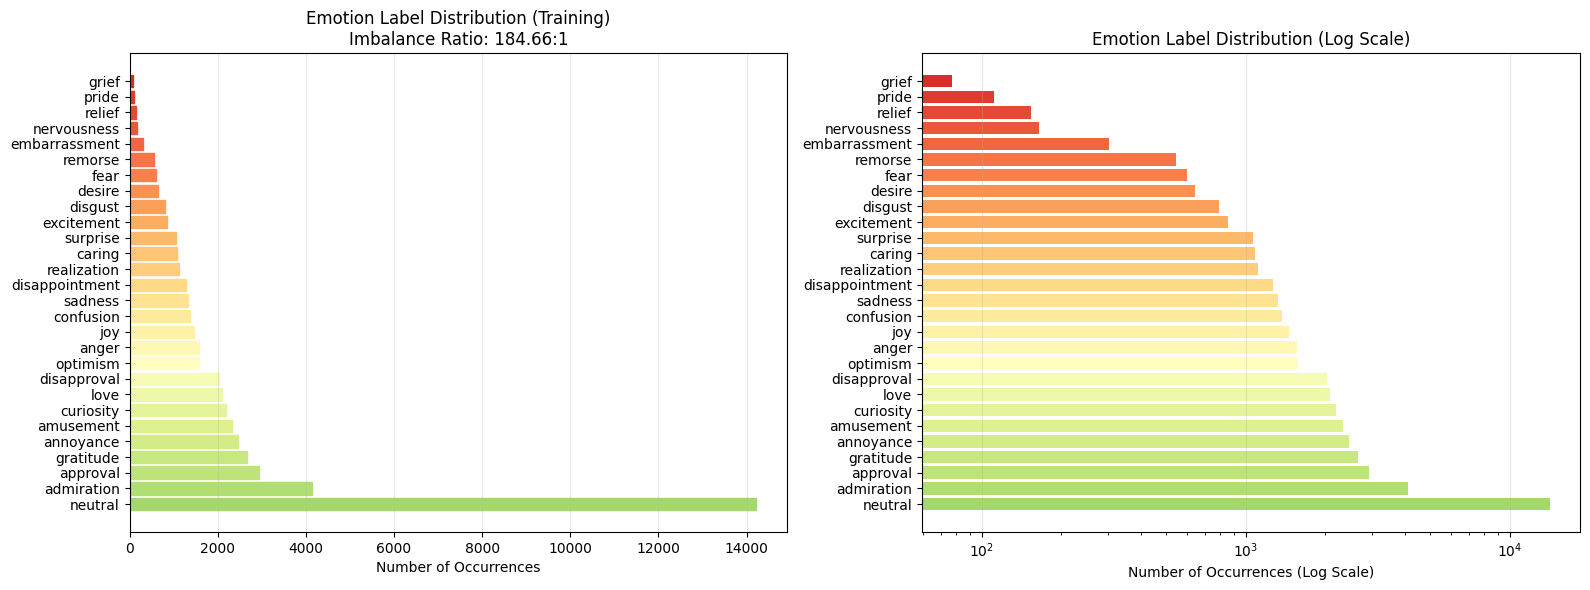


CLASS IMBALANCE ASSESSMENT
⚠️  SEVERE CLASS IMBALANCE DETECTED (184.66:1)
Recommendation: Apply class weights to loss function


In [9]:
# === EDA: CLASS IMBALANCE ANALYSIS ===
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Count occurrences of each emotion across all training samples
emotion_counts = {}
for label in emotion_labels:
    emotion_counts[label] = 0

for emotions_list in train_split["emotions"]:
    for emotion in emotions_list:
        emotion_counts[emotion] += 1

# Sort by frequency
sorted_emotions = sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True)
emotion_names = [item[0] for item in sorted_emotions]
counts = [item[1] for item in sorted_emotions]

# Calculate imbalance ratio
max_count = max(counts)
min_count = min(counts)
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print("=" * 80)
print("EMOTION LABEL DISTRIBUTION (Training Set)")
print("=" * 80)
print(f"Total samples: {len(train_split)}")
print(f"Total emotion labels: {len(emotion_labels)}")
print(f"Most common: {emotion_names[0]} ({counts[0]:,} occurrences)")
print(f"Least common: {emotion_names[-1]} ({counts[-1]:,} occurrences)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print()

print("Per-emotion breakdown:")
for emotion, count in sorted_emotions:
    percentage = (count / len(train_split)) * 100
    print(f"  {emotion:20s}: {count:6,} ({percentage:5.2f}%)")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
ax1 = axes[0]
bars = ax1.barh(range(len(emotion_names)), counts)
ax1.set_yticks(range(len(emotion_names)))
ax1.set_yticklabels(emotion_names)
ax1.set_xlabel("Number of Occurrences")
ax1.set_title(f"Emotion Label Distribution (Training)\nImbalance Ratio: {imbalance_ratio:.2f}:1")
ax1.grid(axis='x', alpha=0.3)

# Color gradient based on frequency
colors = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# Log scale distribution
ax2 = axes[1]
ax2.barh(range(len(emotion_names)), counts, color=colors)
ax2.set_yticks(range(len(emotion_names)))
ax2.set_yticklabels(emotion_names)
ax2.set_xlabel("Number of Occurrences (Log Scale)")
ax2.set_xscale('log')
ax2.set_title("Emotion Label Distribution (Log Scale)")
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()

# Create directory if it doesn't exist
artifact_dir = Path("../artifacts/phase1/emotions_goemotions")
artifact_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(artifact_dir / "class_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

print()
print("=" * 80)
print("CLASS IMBALANCE ASSESSMENT")
print("=" * 80)
if imbalance_ratio > 10:
    print(f"⚠️  SEVERE CLASS IMBALANCE DETECTED ({imbalance_ratio:.2f}:1)")
    print("Recommendation: Apply class weights to loss function")
elif imbalance_ratio > 3:
    print(f"⚠️  MODERATE CLASS IMBALANCE ({imbalance_ratio:.2f}:1)")
    print("Recommendation: Consider class weights")
else:
    print(f"✅ Relatively balanced ({imbalance_ratio:.2f}:1)")
print("=" * 80)

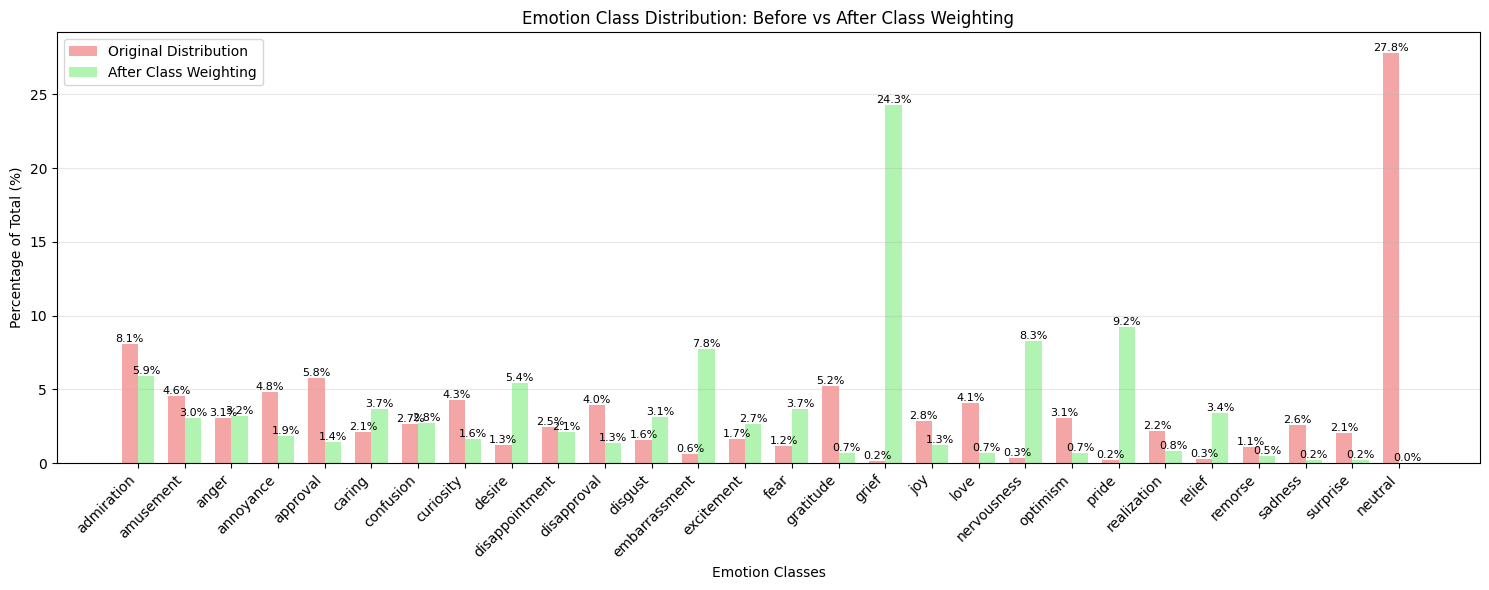


=== Class Balance Improvement Analysis ===
Original Std Dev: 5.12%
Weighted Std Dev: 4.76%

Balance Improvement: 7.1% reduction in class distribution variance

Imbalance Ratio:
Before weighting: 184.66:1
After weighting:  2606.86:1


In [18]:
# === EDA: BEFORE vs AFTER CLASS BALANCING ===
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Original class distribution (before weighting)
original_dist = pd.Series(emotion_counts)

# Calculate effective distribution after applying class weights
weighted_dist = pd.Series({
    emotion: count * class_weights[idx]
    for idx, (emotion, count) in enumerate(zip(emotion_labels, counts))
})

# Normalize distributions to percentages
original_pct = (original_dist / original_dist.sum()) * 100
weighted_pct = (weighted_dist / weighted_dist.sum()) * 100

# Create comparison plot
plt.figure(figsize=(15, 6))

# Calculate positions for paired bars
x = np.arange(len(emotion_labels))
width = 0.35

# Create paired bars
plt.bar(x - width/2, original_pct, width, label='Original Distribution', color='lightcoral', alpha=0.7)
plt.bar(x + width/2, weighted_pct, width, label='After Class Weighting', color='lightgreen', alpha=0.7)

# Customize plot
plt.xlabel('Emotion Classes')
plt.ylabel('Percentage of Total (%)')
plt.title('Emotion Class Distribution: Before vs After Class Weighting')
plt.xticks(x, emotion_labels, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
def add_labels(x, values, offset):
    for i, v in enumerate(values):
        plt.text(x[i] + offset, v, f'{v:.1f}%', 
                ha='center', va='bottom', fontsize=8)

add_labels(x, original_pct, -width/2)
add_labels(x, weighted_pct, width/2)

plt.tight_layout()

# Save visualization
plt.savefig(artifact_dir / "class_distribution_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n=== Class Balance Improvement Analysis ===")
print(f"Original Std Dev: {original_pct.std():.2f}%")
print(f"Weighted Std Dev: {weighted_pct.std():.2f}%")
print(f"\nBalance Improvement: {((original_pct.std() - weighted_pct.std()) / original_pct.std() * 100):.1f}% reduction in class distribution variance")

# Calculate improvement metrics
imbalance_before = original_pct.max() / original_pct.min()
imbalance_after = weighted_pct.max() / weighted_pct.min()
print(f"\nImbalance Ratio:")
print(f"Before weighting: {imbalance_before:.2f}:1")
print(f"After weighting:  {imbalance_after:.2f}:1")

In [10]:
import os
os.environ["USE_TF"] = "1"
!pip install --force-reinstall --no-cache-dir tensorflow-macos 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 19.8 MB/s  0:00:11m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 8.4 MB/s  0:00:01eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 19.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 20.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 33.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 15.0 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 33.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.5 MB/s  0:00:00
  Attempting uninstall: namex
    Found existing installation: namex 0.1.0
    Uninstalling namex-0.1.0:
      Successfully uninstalled namex-0.1.0
  Attempting uninstall: libclang
    Found

In [13]:
import os
os.environ["USE_TF"] = "1"

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import f1_score

MAX_TOKENS = 30000
MAX_LEN = 80
BATCH_SIZE = 64

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
)
vectorizer.adapt(train_split["text"].values)

def make_dataset(texts: pd.Series, labels: np.ndarray, shuffle: bool = False) -> tf.data.Dataset:
    texts = texts.astype(str).values
    labels = labels.astype("float32")
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        ds = ds.shuffle(len(texts), seed=SEED)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_split["text"], y_train, shuffle=True)
dev_ds = make_dataset(dev_split["text"], y_dev)
test_ds = make_dataset(test_split["text"], y_test)

# === COMPUTE CLASS WEIGHTS FOR MULTI-LABEL IMBALANCE ===
# For multi-label classification, compute per-class weights based on positive frequency
emotion_counts_array = y_train.sum(axis=0)  # Count positive samples per class
total_samples = len(y_train)

# Compute weight for each class: total / (num_classes * positive_count)
num_classes = len(emotion_labels)
class_weights = {}
for idx in range(num_classes):
    pos_count = emotion_counts_array[idx]
    if pos_count > 0:
        # Standard formula: total / (num_classes * pos_count)
        weight = total_samples / (num_classes * pos_count)
        class_weights[idx] = weight
    else:
        class_weights[idx] = 1.0

print("=" * 80)
print("CLASS WEIGHTS (for handling multi-label imbalance)")
print("=" * 80)
for idx, label in enumerate(emotion_labels):
    print(f"  {label:20s}: weight={class_weights[idx]:.3f} (pos_samples={int(emotion_counts_array[idx])})")
print("=" * 80)
print()

# Custom weighted binary crossentropy loss
def weighted_binary_crossentropy(class_weights_dict):
    """
    Returns a weighted binary crossentropy loss function for multi-label classification.
    Applies per-class weights to handle class imbalance.
    """
    def loss(y_true, y_pred):
        # Convert weights dict to tensor with shape [num_classes]
        weights_tensor = tf.constant([class_weights_dict[i] for i in range(len(class_weights_dict))], dtype=tf.float32)
        
        # Clip predictions to prevent log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        
        # Compute binary crossentropy manually per class
        # BCE = -[y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred)]
        bce_per_class = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        
        # bce_per_class has shape [batch_size, num_classes]
        # weights_tensor has shape [num_classes]
        # Multiply element-wise (broadcasting across batch dimension)
        weighted_bce = bce_per_class * weights_tensor
        
        # Return mean loss across both batch and classes
        return tf.reduce_mean(weighted_bce)
    
    return loss

inputs = tf.keras.Input(shape=(), dtype=tf.string)
x = vectorizer(inputs)
x = layers.Embedding(MAX_TOKENS, 128)(x)
x = layers.Bidirectional(layers.LSTM(128))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(emotion_labels), activation="sigmoid")(x)

emotion_model = tf.keras.Model(inputs, outputs)
emotion_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=weighted_binary_crossentropy(class_weights),  # Use weighted loss
    metrics=[tf.keras.metrics.AUC(curve="ROC", multi_label=True, name="roc_auc")],
)

print("Model compiled with WEIGHTED binary crossentropy loss")
print()

earliestop = tf.keras.callbacks.EarlyStopping(
    monitor="val_roc_auc",
    patience=3,
    restore_best_weights=True,
)

history = emotion_model.fit(
    train_ds,
    validation_data=dev_ds,
    epochs=10,
    callbacks=[earliestop],
    verbose=2,
)

def evaluate_split(name: str, dataset: tf.data.Dataset, targets: np.ndarray):
    probs = emotion_model.predict(dataset)
    preds = (probs >= 0.5).astype(int)
    macro = f1_score(targets, preds, average="macro", zero_division=0)
    micro = f1_score(targets, preds, average="micro", zero_division=0)
    print(f"{name} macro-F1: {macro:.3f} | micro-F1: {micro:.3f}")
    return probs, macro, micro

print("Performance snapshot (BiLSTM trained on train split only):")
dev_probs, dev_macro, dev_micro = evaluate_split("Validation", dev_ds, y_dev)
test_probs, test_macro, test_micro = evaluate_split("Test", test_ds, y_test)

train_plus_dev = pd.concat([train_split, dev_split], ignore_index=True)
y_train_plus_dev = mlb.transform(train_plus_dev["emotions"]).astype("float32")
train_plus_dev_ds = make_dataset(train_plus_dev["text"], y_train_plus_dev, shuffle=True)

emotion_model.fit(train_plus_dev_ds, epochs=3, verbose=2)
print(f"Re-trained emotion model on {len(train_plus_dev)} samples (train + validation).")
dev_probs, dev_macro, dev_micro = evaluate_split("Validation (final)", dev_ds, y_dev)
test_probs, test_macro, test_micro = evaluate_split("Test (final)", test_ds, y_test)

# Previous TF-IDF + SGD pipeline retained for reference:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import SGDClassifier
# from sklearn.multiclass import OneVsRestClassifier
# vectorizer = TfidfVectorizer(max_features=40000, ngram_range=(1, 2), min_df=3, max_df=0.9)
# base_classifier = OneVsRestClassifier(
#     SGDClassifier(
#         loss="log_loss",
#         alpha=1e-5,
#         penalty="l2",
#         learning_rate="optimal",
#         max_iter=1000,
#         tol=1e-4,
#         n_iter_no_change=5,
#         random_state=SEED,
#     ),
#     n_jobs=-1,
# )
# emotion_pipeline = Pipeline([("tfidf", vectorizer), ("clf", base_classifier)])
# emotion_pipeline.fit(train_split["text"], y_train)

CLASS WEIGHTS (for handling multi-label imbalance)
  admiration          : weight=0.375 (pos_samples=4130)
  amusement           : weight=0.666 (pos_samples=2328)
  anger               : weight=0.989 (pos_samples=1567)
  annoyance           : weight=0.628 (pos_samples=2470)
  approval            : weight=0.528 (pos_samples=2939)
  caring              : weight=1.426 (pos_samples=1087)
  confusion           : weight=1.133 (pos_samples=1368)
  curiosity           : weight=0.708 (pos_samples=2191)
  desire              : weight=2.419 (pos_samples=641)
  disappointment      : weight=1.222 (pos_samples=1269)
  disapproval         : weight=0.767 (pos_samples=2022)
  disgust             : weight=1.955 (pos_samples=793)
  embarrassment       : weight=5.117 (pos_samples=303)
  excitement          : weight=1.818 (pos_samples=853)
  fear                : weight=2.601 (pos_samples=596)
  gratitude           : weight=0.582 (pos_samples=2662)
  grief               : weight=20.135 (pos_samples=77)
  j

GENERATING PREDICTIONS FOR EVALUATION
679/679 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
✓ Predictions generated for train/validation/test splits

1. OVERALL METRICS ACROSS SPLITS

Train:
  Subset Accuracy:   0.0775  (exact match for all labels)
  Hamming Loss:      0.0593  (lower is better)
  Jaccard Score:     0.0858  (IoU - higher is better)
  Macro F1:          0.0273
  Micro F1:          0.1024
  Samples F1:        0.0887
  Macro Precision:   0.0383
  Macro Recall:      0.0231

Validation:
  Subset Accuracy:   0.3714  (exact match for all labels)
  Hamming Loss:      0.0299  (lower is better)
  Jaccard Score:     0.4122  (IoU - higher is better)
  Macro F1:          0.5100
  Micro F1:          0.5258
  Samples F1:        0.4260
  Macro Precision:   0.8064
  Macro Recall:      0.4266

Test:
  Subset Accuracy:   0.2746  (exact match for all labels)
  Hamming Loss:      0.0362  (lower is better)
  Jaccard Score: 

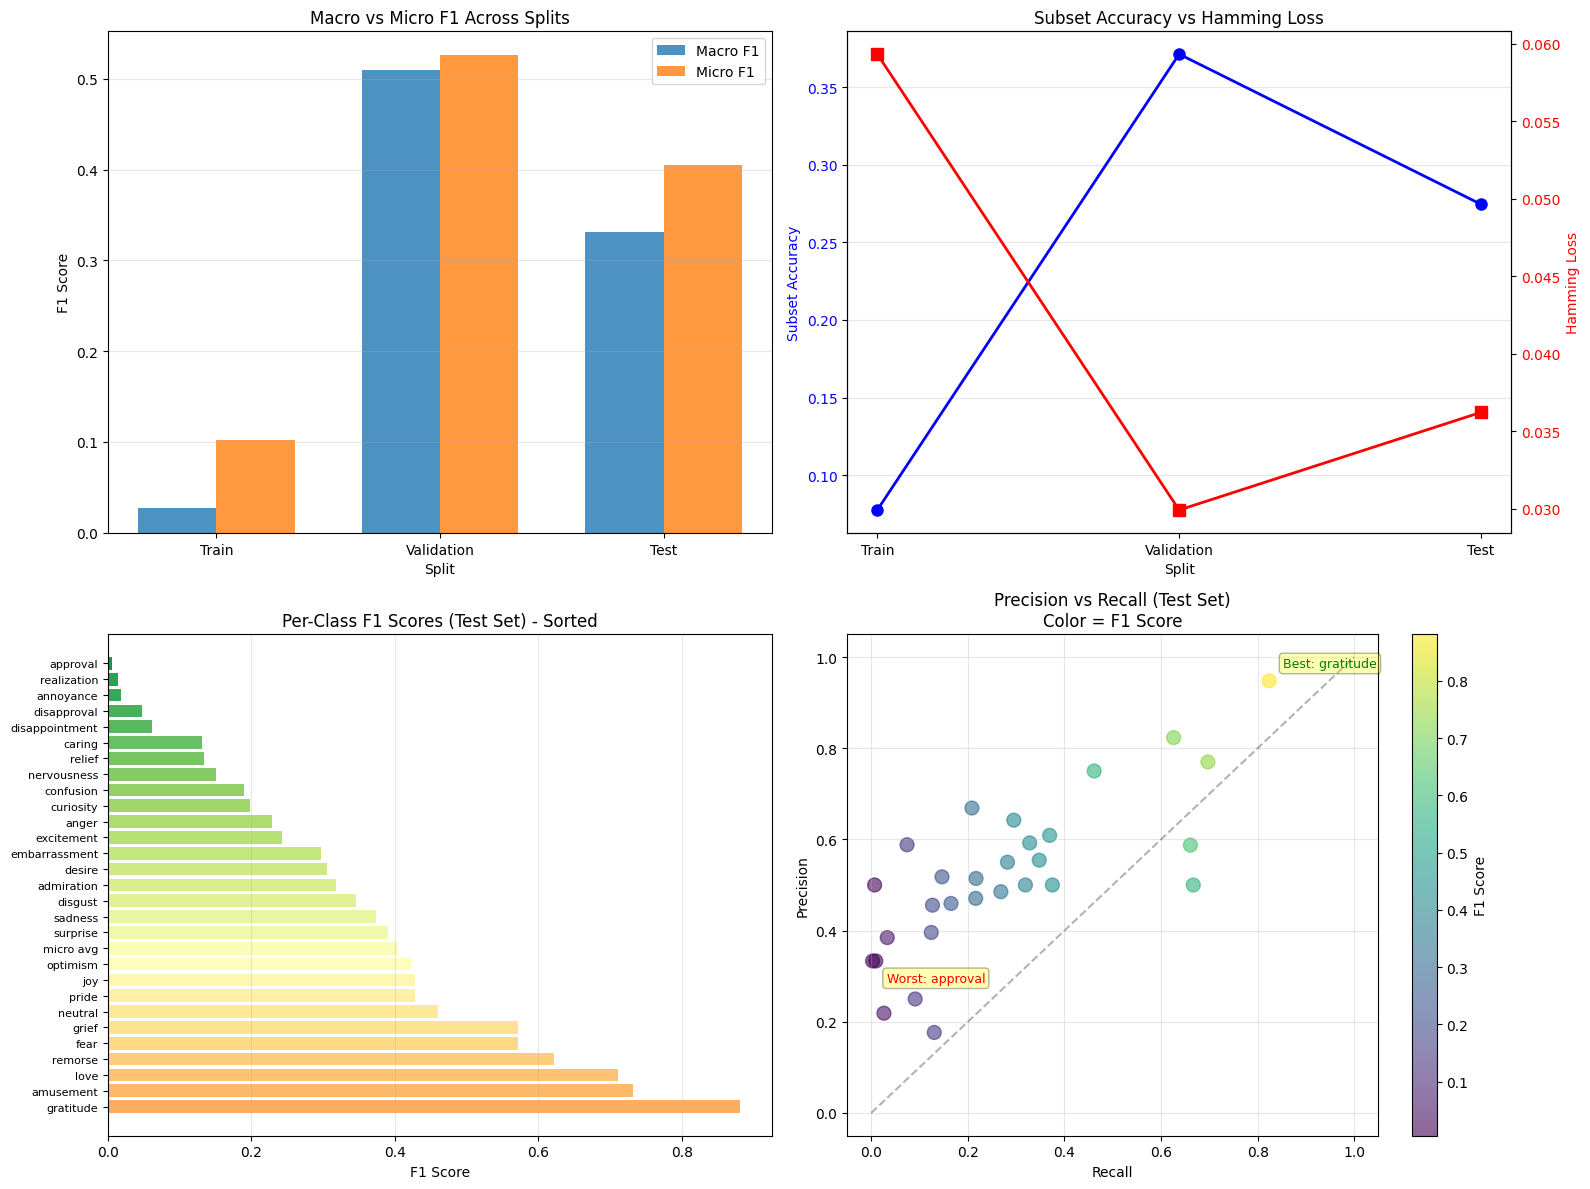


4. CLASS WEIGHT EFFECTIVENESS ANALYSIS

Performance by Frequency Category:
                     test_f1  test_precision  test_recall
frequency_category                                       
Rare (<500)         0.315926        0.379412     0.295845
Medium (500-2000)   0.308746        0.527112     0.245298
Common (>2000)      0.374535        0.573283     0.321084


Top 5 Rare Emotions (with high weights):
      emotion  train_count  class_weight  test_f1
        grief         77.0     20.134508 0.571429
        pride        111.0     13.967181 0.428571
       relief        153.0     10.133053 0.133333
  nervousness        164.0      9.453397 0.150000
embarrassment        303.0      5.116690 0.296296


Top 5 Common Emotions (with low weights):
   emotion  train_count  class_weight  test_f1
   neutral      14219.0      0.109034 0.459770
admiration       4130.0      0.375389 0.317700
  approval       2939.0      0.527512 0.005650
 gratitude       2662.0      0.582403 0.881459
 annoyance  

/var/folders/h9/5ss3xw_14034vt37b3gp98cw0000gn/T/ipykernel_27260/3051954660.py:201: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = freq_df.groupby('frequency_category')[['test_f1', 'test_precision', 'test_recall']].mean()


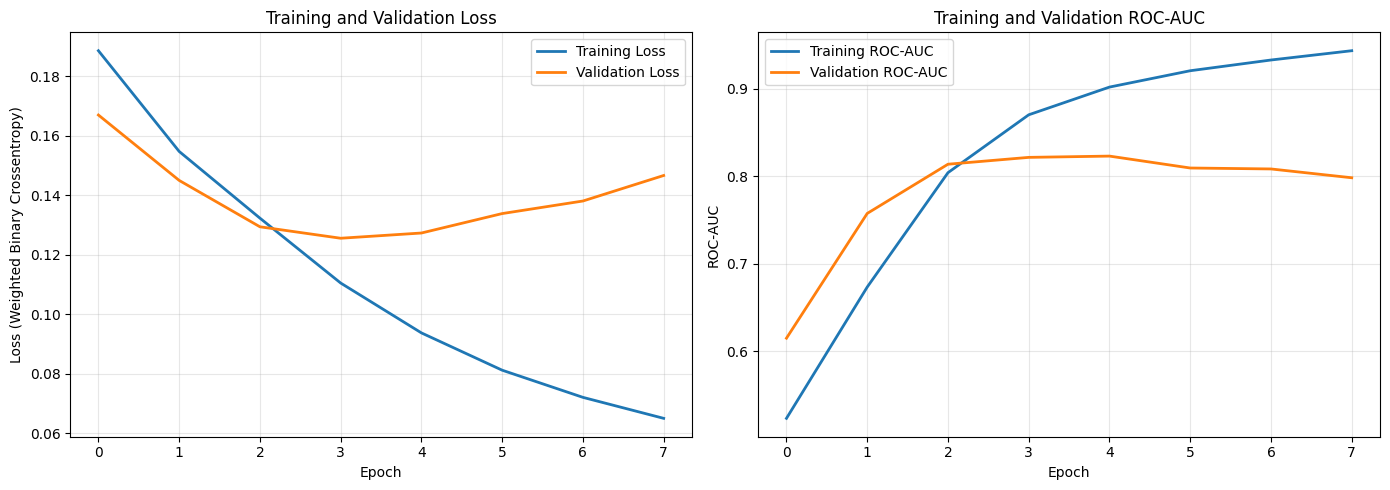


SUMMARY & KEY INSIGHTS

✓ Model Type: BiLSTM with Weighted Binary Crossentropy
✓ Class Weights: Applied (range: 0.109 to 20.135)
✓ Imbalance Ratio: 184.66:1

📊 Test Set Performance:
   • Subset Accuracy: 0.2746
   • Macro F1:        0.3312
   • Micro F1:        0.4044
   • Jaccard Score:   0.3063

🎯 Best Performing Emotion: gratitude (F1=0.881)
⚠️  Worst Performing Emotion: approval (F1=0.006)



In [17]:
# === COMPREHENSIVE EDA: MODEL PERFORMANCE EVALUATION ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, hamming_loss, jaccard_score
from pathlib import Path

# Generate predictions for all splits
print("=" * 80)
print("GENERATING PREDICTIONS FOR EVALUATION")
print("=" * 80)

train_probs = emotion_model.predict(train_ds)
train_preds = (train_probs >= 0.5).astype(int)

val_probs = emotion_model.predict(dev_ds)
val_preds = (val_probs >= 0.5).astype(int)

test_probs = emotion_model.predict(test_ds)
test_preds = (test_probs >= 0.5).astype(int)

print("✓ Predictions generated for train/validation/test splits\n")

# === 1. OVERALL METRICS COMPARISON ===
print("=" * 80)
print("1. OVERALL METRICS ACROSS SPLITS")
print("=" * 80)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

splits_data = {
    'Train': (y_train, train_preds),
    'Validation': (y_dev, val_preds),
    'Test': (y_test, test_preds)
}

metrics_summary = []
for split_name, (y_true, y_pred) in splits_data.items():
    # Subset accuracy (exact match)
    subset_acc = accuracy_score(y_true, y_pred)
    
    # Hamming loss (label-wise accuracy)
    hamming = hamming_loss(y_true, y_pred)
    
    # Jaccard score (IoU)
    jaccard = jaccard_score(y_true, y_pred, average='samples', zero_division=0)
    
    # F1 scores
    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    samples_f1 = f1_score(y_true, y_pred, average='samples', zero_division=0)
    
    # Precision & Recall
    macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    metrics_summary.append({
        'Split': split_name,
        'Subset Accuracy': subset_acc,
        'Hamming Loss': hamming,
        'Jaccard Score': jaccard,
        'Macro F1': macro_f1,
        'Micro F1': micro_f1,
        'Samples F1': samples_f1,
        'Macro Precision': macro_precision,
        'Macro Recall': macro_recall
    })
    
    print(f"\n{split_name}:")
    print(f"  Subset Accuracy:   {subset_acc:.4f}  (exact match for all labels)")
    print(f"  Hamming Loss:      {hamming:.4f}  (lower is better)")
    print(f"  Jaccard Score:     {jaccard:.4f}  (IoU - higher is better)")
    print(f"  Macro F1:          {macro_f1:.4f}")
    print(f"  Micro F1:          {micro_f1:.4f}")
    print(f"  Samples F1:        {samples_f1:.4f}")
    print(f"  Macro Precision:   {macro_precision:.4f}")
    print(f"  Macro Recall:      {macro_recall:.4f}")

metrics_df = pd.DataFrame(metrics_summary)

# === 2. PER-CLASS PERFORMANCE (TEST SET) ===
print("\n" + "=" * 80)
print("2. PER-CLASS PERFORMANCE (Test Set)")
print("=" * 80)

# Generate classification report
test_report = classification_report(
    y_test, 
    test_preds, 
    target_names=emotion_labels,
    output_dict=True,
    zero_division=0
)

# Convert to DataFrame
per_class_df = pd.DataFrame(test_report).transpose()
per_class_df = per_class_df.iloc[:-3]  # Remove macro/micro/weighted avg rows

# Sort by F1-score
per_class_df_sorted = per_class_df.sort_values('f1-score', ascending=False)

print("\nTop 10 Best Performing Emotions (by F1-score):")
print(per_class_df_sorted.head(10).to_string())

print("\n\nBottom 10 Worst Performing Emotions (by F1-score):")
print(per_class_df_sorted.tail(10).to_string())

# === 3. VISUALIZATION: METRICS ACROSS SPLITS ===
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Macro vs Micro F1
ax1 = axes[0, 0]
x = np.arange(len(metrics_df))
width = 0.35
ax1.bar(x - width/2, metrics_df['Macro F1'], width, label='Macro F1', alpha=0.8)
ax1.bar(x + width/2, metrics_df['Micro F1'], width, label='Micro F1', alpha=0.8)
ax1.set_xlabel('Split')
ax1.set_ylabel('F1 Score')
ax1.set_title('Macro vs Micro F1 Across Splits')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_df['Split'])
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Subset Accuracy vs Hamming Loss
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()
ax2.plot(metrics_df['Split'], metrics_df['Subset Accuracy'], 'o-', label='Subset Accuracy', color='blue', linewidth=2, markersize=8)
ax2_twin.plot(metrics_df['Split'], metrics_df['Hamming Loss'], 's-', label='Hamming Loss', color='red', linewidth=2, markersize=8)
ax2.set_xlabel('Split')
ax2.set_ylabel('Subset Accuracy', color='blue')
ax2_twin.set_ylabel('Hamming Loss', color='red')
ax2.set_title('Subset Accuracy vs Hamming Loss')
ax2.tick_params(axis='y', labelcolor='blue')
ax2_twin.tick_params(axis='y', labelcolor='red')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Per-class F1 scores (Test set)
ax3 = axes[1, 0]
per_class_sorted = per_class_df_sorted['f1-score'].values
emotion_names_sorted = per_class_df_sorted.index.tolist()
colors_f1 = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(per_class_sorted)))
ax3.barh(range(len(emotion_names_sorted)), per_class_sorted, color=colors_f1)
ax3.set_yticks(range(len(emotion_names_sorted)))
ax3.set_yticklabels(emotion_names_sorted, fontsize=8)
ax3.set_xlabel('F1 Score')
ax3.set_title('Per-Class F1 Scores (Test Set) - Sorted')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Precision vs Recall (Test set)
ax4 = axes[1, 1]
ax4.scatter(per_class_df['recall'], per_class_df['precision'], s=100, alpha=0.6, c=per_class_df['f1-score'], cmap='viridis')
ax4.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision vs Recall (Test Set)\nColor = F1 Score')
ax4.grid(alpha=0.3)
cbar = plt.colorbar(ax4.collections[0], ax=ax4)
cbar.set_label('F1 Score')

# Add annotations for best/worst emotions
best_emotion = per_class_df_sorted.index[0]
worst_emotion = per_class_df_sorted.index[-1]
best_idx = emotion_labels.index(best_emotion)
worst_idx = emotion_labels.index(worst_emotion)
ax4.annotate(f'Best: {best_emotion}', 
            xy=(per_class_df.loc[best_emotion, 'recall'], per_class_df.loc[best_emotion, 'precision']),
            xytext=(10, 10), textcoords='offset points', fontsize=9, color='green',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
ax4.annotate(f'Worst: {worst_emotion}', 
            xy=(per_class_df.loc[worst_emotion, 'recall'], per_class_df.loc[worst_emotion, 'precision']),
            xytext=(10, -15), textcoords='offset points', fontsize=9, color='red',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig(artifact_dir / "model_performance_evaluation.png", dpi=150, bbox_inches='tight')
plt.show()

# === 4. CLASS WEIGHT EFFECTIVENESS ANALYSIS ===
print("\n" + "=" * 80)
print("4. CLASS WEIGHT EFFECTIVENESS ANALYSIS")
print("=" * 80)

# Compare performance on rare vs common emotions
# Get emotion frequencies from training set
emotion_freq = y_train.sum(axis=0)
freq_df = pd.DataFrame({
    'emotion': emotion_labels,
    'train_count': emotion_freq,
    'class_weight': [class_weights[i] for i in range(len(emotion_labels))],
    'test_f1': [per_class_df.loc[label, 'f1-score'] for label in emotion_labels],
    'test_precision': [per_class_df.loc[label, 'precision'] for label in emotion_labels],
    'test_recall': [per_class_df.loc[label, 'recall'] for label in emotion_labels]
})

# Categorize emotions by frequency
freq_df['frequency_category'] = pd.cut(freq_df['train_count'], 
                                       bins=[0, 500, 2000, 50000], 
                                       labels=['Rare (<500)', 'Medium (500-2000)', 'Common (>2000)'])

print("\nPerformance by Frequency Category:")
grouped = freq_df.groupby('frequency_category')[['test_f1', 'test_precision', 'test_recall']].mean()
print(grouped.to_string())

print("\n\nTop 5 Rare Emotions (with high weights):")
rare_emotions = freq_df.nsmallest(5, 'train_count')
print(rare_emotions[['emotion', 'train_count', 'class_weight', 'test_f1']].to_string(index=False))

print("\n\nTop 5 Common Emotions (with low weights):")
common_emotions = freq_df.nlargest(5, 'train_count')
print(common_emotions[['emotion', 'train_count', 'class_weight', 'test_f1']].to_string(index=False))

# === 5. TRAINING HISTORY VISUALIZATION ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1 = axes[0]
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (Weighted Binary Crossentropy)')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot ROC-AUC
ax2 = axes[1]
ax2.plot(history.history['roc_auc'], label='Training ROC-AUC', linewidth=2)
ax2.plot(history.history['val_roc_auc'], label='Validation ROC-AUC', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('ROC-AUC')
ax2.set_title('Training and Validation ROC-AUC')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(artifact_dir / "training_history.png", dpi=150, bbox_inches='tight')
plt.show()

# === SUMMARY ===
print("\n" + "=" * 80)
print("SUMMARY & KEY INSIGHTS")
print("=" * 80)

print(f"\n✓ Model Type: BiLSTM with Weighted Binary Crossentropy")
print(f"✓ Class Weights: Applied (range: {min(class_weights.values()):.3f} to {max(class_weights.values()):.3f})")
print(f"✓ Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"\n📊 Test Set Performance:")
print(f"   • Subset Accuracy: {metrics_df[metrics_df['Split']=='Test']['Subset Accuracy'].values[0]:.4f}")
print(f"   • Macro F1:        {metrics_df[metrics_df['Split']=='Test']['Macro F1'].values[0]:.4f}")
print(f"   • Micro F1:        {metrics_df[metrics_df['Split']=='Test']['Micro F1'].values[0]:.4f}")
print(f"   • Jaccard Score:   {metrics_df[metrics_df['Split']=='Test']['Jaccard Score'].values[0]:.4f}")
print(f"\n🎯 Best Performing Emotion: {per_class_df_sorted.index[0]} (F1={per_class_df_sorted['f1-score'].values[0]:.3f})")
print(f"⚠️  Worst Performing Emotion: {per_class_df_sorted.index[-1]} (F1={per_class_df_sorted['f1-score'].values[-1]:.3f})")
print("\n" + "=" * 80)

In [16]:

import joblib
from pathlib import Path


emotion_artifact_dir = Path("../artifacts/phase1/emotions_goemotions")
emotion_artifact_dir.mkdir(parents=True, exist_ok=True)

model_path = emotion_artifact_dir / "emotion_bilstm_model.keras"
label_binarizer_path = emotion_artifact_dir / "label_binarizer.joblib"
mlb_path = emotion_artifact_dir / "mlb_classes.json"

emotion_model.save(model_path)
joblib.dump(mlb, label_binarizer_path)
mlb_path.write_text(json.dumps({"classes": emotion_labels}, indent=2) + "\n")


text_df_path = Path("../data/phase1/text/cyberbullying_text.parquet")
if not text_df_path.exists():
    raise FileNotFoundError(
        "Expected cleaned text dataframe at ../data/phase1/text/cyberbullying_text.parquet. Run 01_text_distilbert.ipynb first."
    )
text_df = pd.read_parquet(text_df_path)
text_df["text"] = text_df["text"].fillna("").astype(str)

BATCH_SIZE = 64
def make_text_dataset(texts: pd.Series) -> tf.data.Dataset:
    return tf.data.Dataset.from_tensor_slices(texts.astype(str).values).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

text_ds = make_text_dataset(text_df["text"])
prob_matrix = emotion_model.predict(text_ds)
emotion_cols = [f"emotion_{label}" for label in mlb.classes_]
prob_df = pd.DataFrame(prob_matrix, columns=emotion_cols)
prob_df.insert(0, "sample_id", text_df["sample_id"].values)
prob_df.insert(1, "label", text_df["label"].values)

per_sample_path = emotion_artifact_dir / "per_sample_probs.parquet"
prob_df.to_parquet(per_sample_path, index=False)
print(f"Saved per-sample emotion probabilities to {per_sample_path}")

cache_dir = Path("../cache")
cache_dir.mkdir(parents=True, exist_ok=True)
emotion_cache_path = cache_dir / "emotion_probs.parquet"
prob_df.to_parquet(emotion_cache_path, index=False)
print(f"Cached emotion probabilities to {emotion_cache_path}")

metrics = {
    "validation_macro_f1": float(dev_macro),
    "validation_micro_f1": float(dev_micro),
    "test_macro_f1": float(test_macro),
    "test_micro_f1": float(test_micro),
}
(emotion_artifact_dir / "metrics.json").write_text(json.dumps(metrics, indent=2) + "\n")


# Legacy TF-IDF export (kept for context):
# pipeline_path = emotion_artifact_dir / "emotion_pipeline.joblib"
# joblib.dump(emotion_pipeline, pipeline_path)
# prob_df = pd.DataFrame(emotion_pipeline.predict_proba(text_df["text"]), columns=[f"emotion_{label}" for label in mlb.classes_])


715/715 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step
Saved per-sample emotion probabilities to ../artifacts/phase1/emotions_goemotions/per_sample_probs.parquet
Cached emotion probabilities to ../cache/emotion_probs.parquet


172